In [140]:
import pandas as pd
import numpy as np
import requests
import pvlib
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [141]:
# paths to your CSV files
csv_path_1 = "openmeteo_weather_data.csv"
csv_path_2 = "pvlibclear_sky_features.csv"

# load and combine
df1 = pd.read_csv(csv_path_1)
df2 = pd.read_csv(csv_path_2)
df = df1.join(df2, how="inner")

# optionally save
df.to_csv("fulldata", index=False)
df.head()

,time,cloud_cover,temperature,humidity,wind_speed,precipitation,solar_ghi,Unnamed: 0,solar_zenith,solar_azimuth,air_mass,clear_sky_ghi,clear_sky_dni
0,2025-11-01 00:00:00,95,24.1,91,5.6,0.0,0.0,2025-11-01 00:00:00+05:30,172.687521,166.029557,NaN,0.0,0.0
1,2025-11-01 01:00:00,96,24.0,90,6.0,0.0,0.0,2025-11-01 01:00:00+05:30,162.031494,114.704504,NaN,0.0,0.0
2,2025-11-01 02:00:00,85,23.8,91,6.1,0.0,0.0,2025-11-01 02:00:00+05:30,147.985597,105.575832,NaN,0.0,0.0
3,2025-11-01 03:00:00,79,23.4,92,4.6,0.0,0.0,2025-11-01 03:00:00+05:30,133.549500,102.985758,NaN,0.0,0.0
4,2025-11-01 04:00:00,100,23.0,94,4.3,0.0,0.0,2025-11-01 04:00:00+05:30,119.029652,102.489930,NaN,0.0,0.0


In [142]:
df = df[
    (df["clear_sky_ghi"] > 10) &
    (df["solar_zenith"] < 85)
]

df = df.dropna()
df.head()


,time,cloud_cover,temperature,humidity,wind_speed,precipitation,solar_ghi,Unnamed: 0,solar_zenith,solar_azimuth,air_mass,clear_sky_ghi,clear_sky_dni
7,2025-11-01 07:00:00,66,26.4,84,4.5,0.0,185.0,2025-11-01 07:00:00+05:30,75.741992,106.987746,4.000886,154.512211,370.389594
8,2025-11-01 08:00:00,76,28.5,72,4.0,0.0,426.0,2025-11-01 08:00:00+05:30,61.657682,110.801281,2.099589,406.291355,633.496830
9,2025-11-01 09:00:00,67,30.0,65,5.4,0.0,646.0,2025-11-01 09:00:00+05:30,48.036868,116.996788,1.493545,632.397418,752.370765
10,2025-11-01 10:00:00,68,31.0,62,6.0,0.0,818.0,2025-11-01 10:00:00+05:30,35.430823,127.939005,1.226350,805.450555,811.708305
11,2025-11-01 11:00:00,66,32.3,52,5.6,0.0,913.0,2025-11-01 11:00:00+05:30,25.408590,149.040914,1.106504,910.781205,839.834329


In [143]:
df["Kt"] = df["solar_ghi"] / df["clear_sky_ghi"]
df = df[(df["Kt"] >= 0) & (df["Kt"] <= 1.2)]
df.head()

,time,cloud_cover,temperature,humidity,wind_speed,precipitation,solar_ghi,Unnamed: 0,solar_zenith,solar_azimuth,air_mass,clear_sky_ghi,clear_sky_dni,Kt
7,2025-11-01 07:00:00,66,26.4,84,4.5,0.0,185.0,2025-11-01 07:00:00+05:30,75.741992,106.987746,4.000886,154.512211,370.389594,1.197316
8,2025-11-01 08:00:00,76,28.5,72,4.0,0.0,426.0,2025-11-01 08:00:00+05:30,61.657682,110.801281,2.099589,406.291355,633.496830,1.048509
9,2025-11-01 09:00:00,67,30.0,65,5.4,0.0,646.0,2025-11-01 09:00:00+05:30,48.036868,116.996788,1.493545,632.397418,752.370765,1.021510
10,2025-11-01 10:00:00,68,31.0,62,6.0,0.0,818.0,2025-11-01 10:00:00+05:30,35.430823,127.939005,1.226350,805.450555,811.708305,1.015581
11,2025-11-01 11:00:00,66,32.3,52,5.6,0.0,913.0,2025-11-01 11:00:00+05:30,25.408590,149.040914,1.106504,910.781205,839.834329,1.002436


In [144]:
# ensure time column exists and create calendar features
if "time" in df.columns:
    df["time"] = pd.to_datetime(df["time"])
else:
    # if time was saved as index in CSV, bring it back
    if df.index.name == "time":
        df = df.reset_index()
        df["time"] = pd.to_datetime(df["time"])
    else:
        raise ValueError("time column missing; verify input CSVs")

# derive hour-of-day and day-of-year for model features
df["hour"] = df["time"].dt.hour
df["day_of_year"] = df["time"].dt.dayofyear


In [145]:
FEATURES = [
    "cloud_cover",
    "temperature",
    "humidity",
    "wind_speed",
    "solar_zenith",
    "air_mass",
    "hour",
    "day_of_year"
]

TARGET = "Kt"


In [146]:
n = len(df)
train_end = int(n * 0.7)
val_end   = int(n * 0.85)

X_train = df[FEATURES].iloc[:train_end]
y_train = df[TARGET].iloc[:train_end]

X_val = df[FEATURES].iloc[train_end:val_end]
y_val = df[TARGET].iloc[train_end:val_end]

X_test = df[FEATURES].iloc[val_end:]
y_test = df[TARGET].iloc[val_end:]

clear_test = df["clear_sky_ghi"].iloc[val_end:]
ghi_actual = df["solar_ghi"].iloc[val_end:]


In [147]:
model = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.009,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [148]:
Kt_pred = model.predict(X_test)
GHI_pred = Kt_pred * clear_test


In [149]:
mae = mean_absolute_error(ghi_actual, GHI_pred)
rmse = mean_squared_error(ghi_actual, GHI_pred) ** 0.5
r2 = r2_score(ghi_actual, GHI_pred)

print(f"MAE  : {mae:.2f} W/m²")
print(f"RMSE : {rmse:.2f} W/m²")
print(f"R²   : {r2:.3f}")


MAE  : 40.08 W/m²
RMSE : 48.21 W/m²
R²   : 0.961


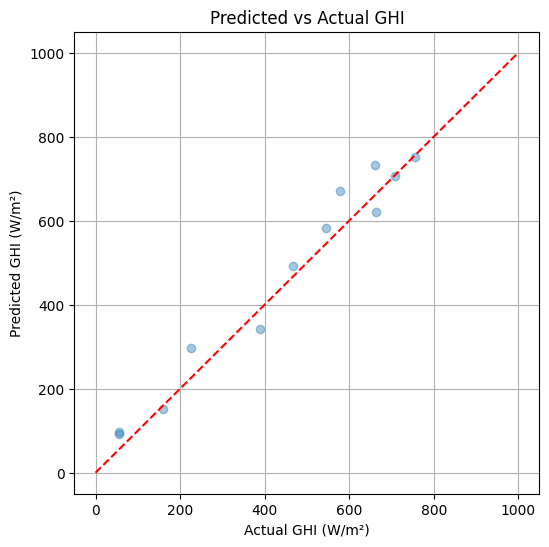

In [150]:
plt.figure(figsize=(6,6))
plt.scatter(ghi_actual, GHI_pred, alpha=0.4)
plt.plot([0,1000],[0,1000], 'r--')
plt.xlabel("Actual GHI (W/m²)")
plt.ylabel("Predicted GHI (W/m²)")
plt.title("Predicted vs Actual GHI")
plt.grid()
plt.show()


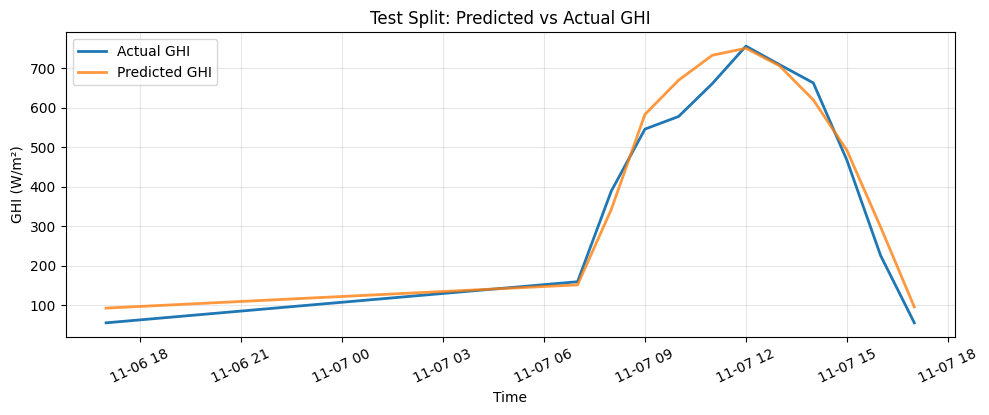

In [151]:
# Time-series plot: predicted vs actual GHI on test split
if "time" not in df.columns:
    raise ValueError("time column missing; rerun preprocessing cells")

time_axis = df["time"].iloc[val_end:]

plt.figure(figsize=(10,4))
plt.plot(time_axis, ghi_actual, label="Actual GHI", linewidth=2)
plt.plot(time_axis, GHI_pred, label="Predicted GHI", linewidth=2, alpha=0.8)
plt.xlabel("Time")
plt.ylabel("GHI (W/m²)")
plt.title("Test Split: Predicted vs Actual GHI")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.xticks(rotation=25)
plt.show()


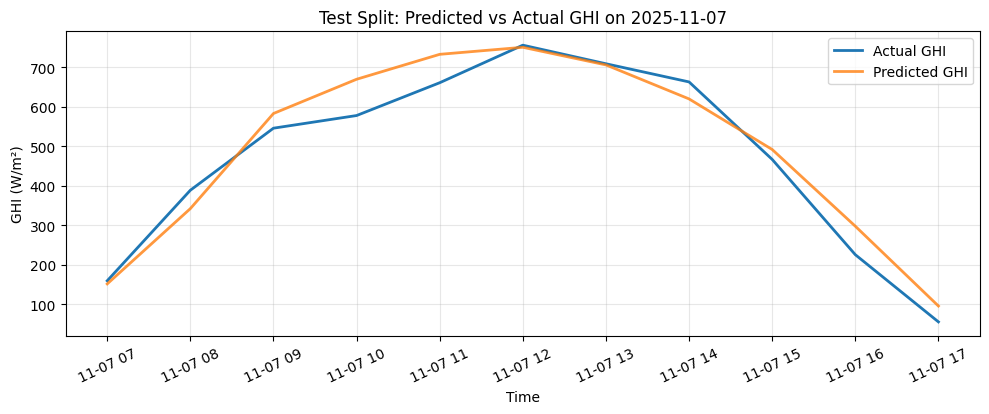

In [152]:
# Time-series plot for a single day (11-07) on test split
if "time" not in df.columns:
    raise ValueError("time column missing; rerun preprocessing cells")

target_date = pd.to_datetime("2025-11-07").date()

time_axis = df["time"].iloc[val_end:]
mask = time_axis.dt.date == target_date

if mask.any():
    plt.figure(figsize=(10,4))
    plt.plot(time_axis[mask], ghi_actual[mask], label="Actual GHI", linewidth=2)
    plt.plot(time_axis[mask], GHI_pred[mask], label="Predicted GHI", linewidth=2, alpha=0.8)
    plt.xlabel("Time")
    plt.ylabel("GHI (W/m²)")
    plt.title("Test Split: Predicted vs Actual GHI on 2025-11-07")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.xticks(rotation=25)
    plt.show()
else:
    print("No test data found for 2025-11-07; adjust target_date if needed.")


In [153]:
# Load Solcast GHI data and compare with predictions
solcast_csv = "solcast_nov_2025_1stweek_hourly.csv"
df_solcast = pd.read_csv(solcast_csv)

# Parse time column - convert to tz-naive to match test data
df_solcast["time"] = pd.to_datetime(df_solcast["period_end"]).dt.tz_localize(None)

# Filter to same date range as test data
time_axis = df["time"].iloc[val_end:]
start_time = pd.Timestamp(time_axis.min())
end_time = pd.Timestamp(time_axis.max())

df_solcast_filtered = df_solcast[
    (df_solcast["time"] >= start_time) & 
    (df_solcast["time"] <= end_time)
].copy()

print(f"Solcast data points: {len(df_solcast_filtered)}")
print(f"Test data points: {len(time_axis)}")
df_solcast_filtered.head()


Solcast data points: 24
Test data points: 12


,dhi,dni,ghi,gti,period_end,period,time
137,77,44,88,91,2025-11-06 17:30:00+05:30,PT1H,2025-11-06 17:30:00
138,1,0,1,1,2025-11-06 18:30:00+05:30,PT1H,2025-11-06 18:30:00
139,0,0,0,0,2025-11-06 19:30:00+05:30,PT1H,2025-11-06 19:30:00
140,0,0,0,0,2025-11-06 20:30:00+05:30,PT1H,2025-11-06 20:30:00
141,0,0,0,0,2025-11-06 21:30:00+05:30,PT1H,2025-11-06 21:30:00


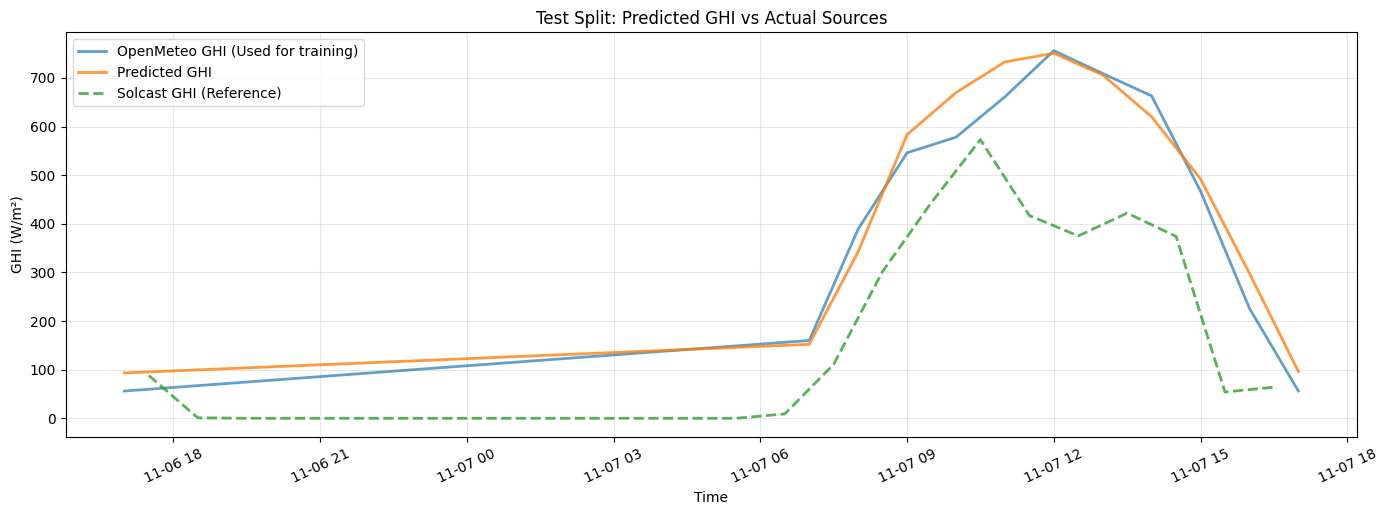

In [154]:
# Plot Solcast GHI vs Predicted GHI over time
plt.figure(figsize=(14,5))
plt.plot(time_axis, ghi_actual, label="OpenMeteo GHI (Used for training)", linewidth=2, alpha=0.7)
plt.plot(time_axis, GHI_pred, label="Predicted GHI", linewidth=2, alpha=0.8)
plt.plot(df_solcast_filtered["time"], df_solcast_filtered["ghi"], 
         label="Solcast GHI (Reference)", linewidth=2, linestyle='--', alpha=0.8)
plt.xlabel("Time")
plt.ylabel("GHI (W/m²)")
plt.title("Test Split: Predicted GHI vs Actual Sources")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.xticks(rotation=25)
plt.show()


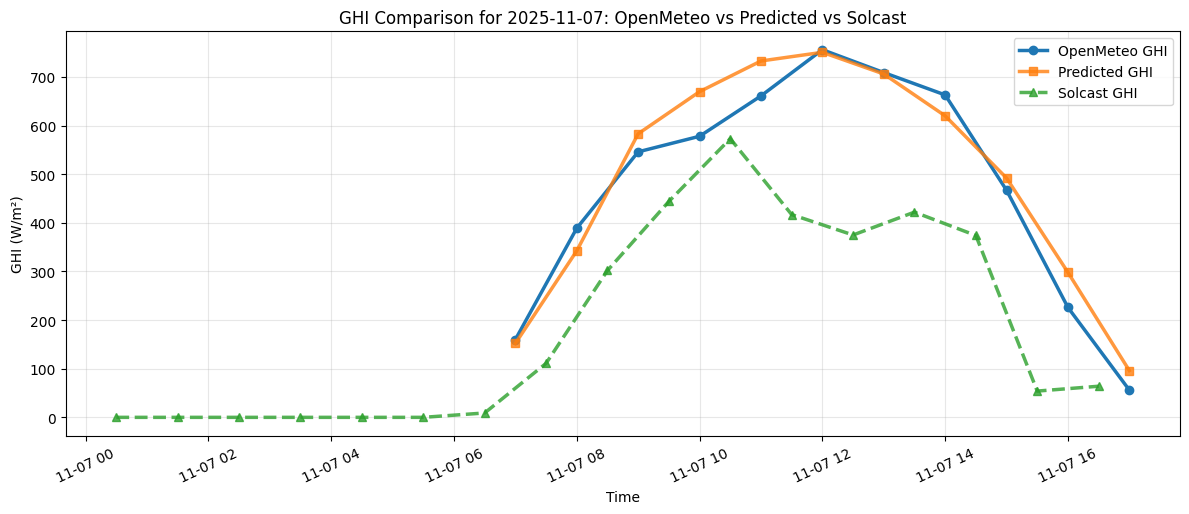

In [155]:
# Plot all GHI sources for 2025-11-07
target_date = pd.to_datetime("2025-11-07").date()

# Filter test data
time_axis = df["time"].iloc[val_end:]
mask = time_axis.dt.date == target_date

# Filter Solcast data
solcast_mask = df_solcast_filtered["time"].dt.date == target_date

if mask.any() and solcast_mask.any():
    plt.figure(figsize=(12,5))
    plt.plot(time_axis[mask], ghi_actual[mask], label="OpenMeteo GHI", linewidth=2.5, marker='o')
    plt.plot(time_axis[mask], GHI_pred[mask], label="Predicted GHI", linewidth=2.5, marker='s', alpha=0.8)
    plt.plot(df_solcast_filtered[solcast_mask]["time"], df_solcast_filtered[solcast_mask]["ghi"], 
             label="Solcast GHI", linewidth=2.5, linestyle='--', marker='^', alpha=0.8)
    plt.xlabel("Time")
    plt.ylabel("GHI (W/m²)")
    plt.title("GHI Comparison for 2025-11-07: OpenMeteo vs Predicted vs Solcast")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.xticks(rotation=25)
    plt.show()
else:
    print("No data found for 2025-11-07 in one or more sources.")


## Train New Model Using Solcast GHI Data

Now we'll train a new XGBoost model using Solcast GHI as the target instead of OpenMeteo GHI.

In [156]:
# Load full Solcast dataset
df_solcast_full = pd.read_csv("solcast_nov_2025_1stweek_hourly.csv")

# Parse and normalize times - Solcast period_end is offset by 30 min
df_solcast_full["time"] = pd.to_datetime(df_solcast_full["period_end"]).dt.tz_localize(None)
# Round to nearest hour to match OpenMeteo hourly data
df_solcast_full["time"] = df_solcast_full["time"].dt.floor('h')

print("Solcast time range:")
print(f"  Start: {df_solcast_full['time'].min()}")
print(f"  End: {df_solcast_full['time'].max()}")

print("\nOpenMeteo time range:")
print(f"  Start: {df['time'].min()}")
print(f"  End: {df['time'].max()}")

# Now merge
df_solcast_combined = df.copy()
df_solcast_combined = df_solcast_combined.rename(columns={"solar_ghi": "openmeteo_ghi"})

df_solcast_combined = df_solcast_combined.merge(
    df_solcast_full[["time", "ghi"]], 
    on="time", 
    how="left"
).rename(columns={"ghi": "solcast_ghi"})

df_solcast_combined = df_solcast_combined.dropna(subset=["solcast_ghi"])

print(f"\nCombined Solcast dataset shape: {df_solcast_combined.shape}")
df_solcast_combined.head()


Solcast time range:
  Start: 2025-11-01 00:00:00
  End: 2025-11-08 00:00:00

OpenMeteo time range:
  Start: 2025-11-01 07:00:00
  End: 2025-11-07 17:00:00

Combined Solcast dataset shape: (76, 17)


,time,cloud_cover,temperature,humidity,wind_speed,precipitation,openmeteo_ghi,Unnamed: 0,solar_zenith,solar_azimuth,air_mass,clear_sky_ghi,clear_sky_dni,Kt,hour,day_of_year,solcast_ghi
0,2025-11-01 07:00:00,66,26.4,84,4.5,0.0,185.0,2025-11-01 07:00:00+05:30,75.741992,106.987746,4.000886,154.512211,370.389594,1.197316,7,305,168
1,2025-11-01 08:00:00,76,28.5,72,4.0,0.0,426.0,2025-11-01 08:00:00+05:30,61.657682,110.801281,2.099589,406.291355,633.496830,1.048509,8,305,404
2,2025-11-01 09:00:00,67,30.0,65,5.4,0.0,646.0,2025-11-01 09:00:00+05:30,48.036868,116.996788,1.493545,632.397418,752.370765,1.021510,9,305,624
3,2025-11-01 10:00:00,68,31.0,62,6.0,0.0,818.0,2025-11-01 10:00:00+05:30,35.430823,127.939005,1.226350,805.450555,811.708305,1.015581,10,305,791
4,2025-11-01 11:00:00,66,32.3,52,5.6,0.0,913.0,2025-11-01 11:00:00+05:30,25.408590,149.040914,1.106504,910.781205,839.834329,1.002436,11,305,893


In [157]:
# Prepare data for Solcast-based model
# Filter and compute Kt using Solcast GHI
df_sc = df_solcast_combined[
    (df_solcast_combined["clear_sky_ghi"] > 10) &
    (df_solcast_combined["solar_zenith"] < 85) &
    (df_solcast_combined["solcast_ghi"] > 0)  # Remove nighttime/zero GHI data
].copy()

# Compute Kt using Solcast GHI
df_sc["Kt_solcast"] = df_sc["solcast_ghi"] / df_sc["clear_sky_ghi"]
df_sc = df_sc[(df_sc["Kt_solcast"] >= 0) & (df_sc["Kt_solcast"] <= 1.2)]

print(f"Filtered Solcast dataset: {df_sc.shape}")
print(f"\nKt_solcast statistics:")
print(df_sc["Kt_solcast"].describe())


Filtered Solcast dataset: (76, 18)

Kt_solcast statistics:
count    76.000000
mean      0.736442
std       0.210038
min       0.093787
25%       0.625750
50%       0.744136
75%       0.921272
max       1.087293
Name: Kt_solcast, dtype: float64


In [158]:

df_sc.head()

,time,cloud_cover,temperature,humidity,wind_speed,precipitation,openmeteo_ghi,Unnamed: 0,solar_zenith,solar_azimuth,air_mass,clear_sky_ghi,clear_sky_dni,Kt,hour,day_of_year,solcast_ghi,Kt_solcast
0,2025-11-01 07:00:00,66,26.4,84,4.5,0.0,185.0,2025-11-01 07:00:00+05:30,75.741992,106.987746,4.000886,154.512211,370.389594,1.197316,7,305,168,1.087293
1,2025-11-01 08:00:00,76,28.5,72,4.0,0.0,426.0,2025-11-01 08:00:00+05:30,61.657682,110.801281,2.099589,406.291355,633.496830,1.048509,8,305,404,0.994360
2,2025-11-01 09:00:00,67,30.0,65,5.4,0.0,646.0,2025-11-01 09:00:00+05:30,48.036868,116.996788,1.493545,632.397418,752.370765,1.021510,9,305,624,0.986721
3,2025-11-01 10:00:00,68,31.0,62,6.0,0.0,818.0,2025-11-01 10:00:00+05:30,35.430823,127.939005,1.226350,805.450555,811.708305,1.015581,10,305,791,0.982059
4,2025-11-01 11:00:00,66,32.3,52,5.6,0.0,913.0,2025-11-01 11:00:00+05:30,25.408590,149.040914,1.106504,910.781205,839.834329,1.002436,11,305,893,0.980477


In [159]:
# Train/val/test split for Solcast model
n_sc = len(df_sc)
train_end_sc = int(n_sc * 0.7)
val_end_sc = int(n_sc * 0.85)

X_train_sc = df_sc[FEATURES].iloc[:train_end_sc]
y_train_sc = df_sc["Kt_solcast"].iloc[:train_end_sc]

X_val_sc = df_sc[FEATURES].iloc[train_end_sc:val_end_sc]
y_val_sc = df_sc["Kt_solcast"].iloc[train_end_sc:val_end_sc]

X_test_sc = df_sc[FEATURES].iloc[val_end_sc:]
y_test_sc = df_sc["Kt_solcast"].iloc[val_end_sc:]

clear_test_sc = df_sc["clear_sky_ghi"].iloc[val_end_sc:]
ghi_actual_sc = df_sc["solcast_ghi"].iloc[val_end_sc:]

print(f"Training samples: {len(X_train_sc)}")
print(f"Validation samples: {len(X_val_sc)}")
print(f"Test samples: {len(X_test_sc)}")


Training samples: 53
Validation samples: 11
Test samples: 12


In [160]:
FEATURES = [
    "cloud_cover",
    "temperature",
    "humidity",
    "wind_speed",
    "solar_zenith",
    "air_mass",
    "hour",
    "day_of_year"
]

TARGET = "Kt_solcast"


In [161]:
# Train XGBoost model on Solcast data
model_solcast = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.009,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

model_solcast.fit(
    X_train_sc,
    y_train_sc,
    eval_set=[(X_val_sc, y_val_sc)],
    verbose=False
)

print("Solcast model trained successfully!")


Solcast model trained successfully!


In [162]:
# Make predictions and evaluate Solcast model
Kt_pred_sc = model_solcast.predict(X_test_sc)
GHI_pred_sc = Kt_pred_sc * clear_test_sc

mae_sc = mean_absolute_error(ghi_actual_sc, GHI_pred_sc)
rmse_sc = mean_squared_error(ghi_actual_sc, GHI_pred_sc) ** 0.5
r2_sc = r2_score(ghi_actual_sc, GHI_pred_sc)

print("\n=== Solcast Model Performance ===")
print(f"MAE  : {mae_sc:.2f} W/m²")
print(f"RMSE : {rmse_sc:.2f} W/m²")
print(f"R²   : {r2_sc:.3f}")

print("\n=== OpenMeteo Model Performance (for comparison) ===")
print(f"MAE  : {mae:.2f} W/m²")
print(f"RMSE : {rmse:.2f} W/m²")
print(f"R²   : {r2:.3f}")



=== Solcast Model Performance ===
MAE  : 149.67 W/m²
RMSE : 194.02 W/m²
R²   : -0.166

=== OpenMeteo Model Performance (for comparison) ===
MAE  : 40.08 W/m²
RMSE : 48.21 W/m²
R²   : 0.961


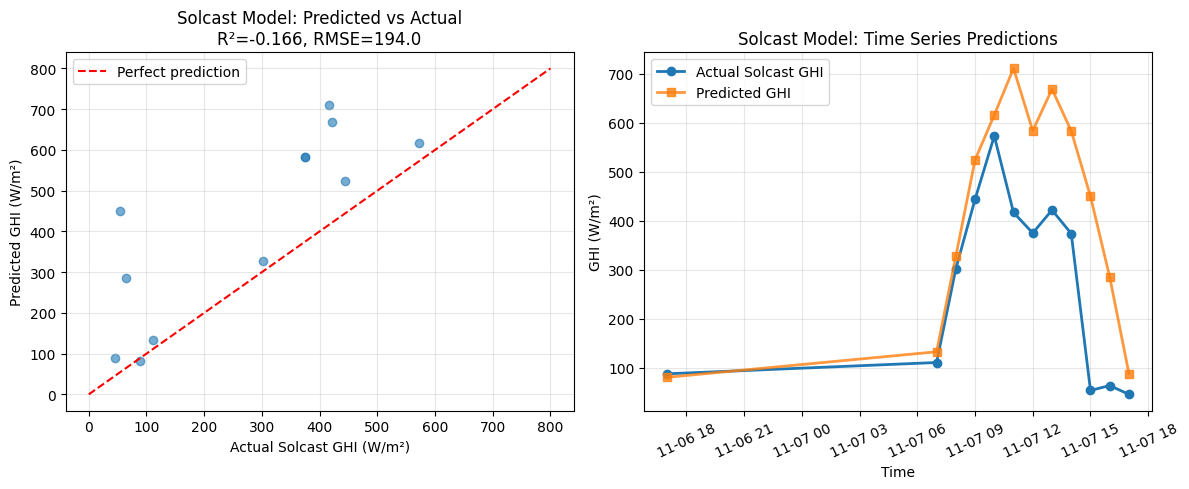

In [163]:
# Visualize Solcast model predictions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(ghi_actual_sc, GHI_pred_sc, alpha=0.6)
plt.plot([0, 800], [0, 800], 'r--', label='Perfect prediction')
plt.xlabel("Actual Solcast GHI (W/m²)")
plt.ylabel("Predicted GHI (W/m²)")
plt.title(f"Solcast Model: Predicted vs Actual\nR²={r2_sc:.3f}, RMSE={rmse_sc:.1f}")
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
time_axis_sc = df_sc["time"].iloc[val_end_sc:]
plt.plot(time_axis_sc, ghi_actual_sc, label="Actual Solcast GHI", linewidth=2, marker='o')
plt.plot(time_axis_sc, GHI_pred_sc, label="Predicted GHI", linewidth=2, marker='s', alpha=0.8)
plt.xlabel("Time")
plt.ylabel("GHI (W/m²)")
plt.title("Solcast Model: Time Series Predictions")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=25)

plt.tight_layout()
plt.show()
